# OSNAP line Lagrangian particle tracking investigation of the cold/fresh blob


### The aim here is an investigation of the source of the cold/fresh blob which appeared in the near-surface Iceland Basin from about 2014. There are a couple of published explanations for the feature: 

- reduced heat/salt transport across RAPID array and northwards to subpolar N Atlantic over several years (Bryden et al. 2020?) or 
- increased contribution from Labrador Sea water flowing into subpolar North Atlantic rather than southwards (Holliday et al. 2020?). Driven I think by specific,  more intermittent, weather near Flemish Cap (though I need to read this again...)

The technique is to track particles back from the OSNAP line for 4 years and identify those which came from the Gulf Stream and those which came through the Labrador Sea. And see how that changes between from 2006 to 2017. (Elsewhere I have done backwards particle tracking for all years between 2006 and 2017. This supports the results shown here and adds some detail, but 2 years tracking isn't really long enough to identify pathways). I am also trying to quantify the volume/heat/salt transports along each route (not here yet though).

## This notebook plots out the tracks and implements some source tests

## Technical preamble

In [1]:
# import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
# from matplotlib.colors import ListedColormap
import cmocean as co
import pandas as pd
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy
import seawater as sw

from matplotlib import colors as c
from matplotlib import ticker
from xhistogram.xarray import histogram

In [2]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=20) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

## Set up paths and read in trajectory data

In [3]:
## Parameters
# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# output figures path
figures_path = Path("reports/figures/ColdBlob/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/osnap/') 
filename_tracks = [
                    'tracks_randomvel_osnap_backward_200601_N6979_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200607_N7846_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200701_N6763_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200707_N7144_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200801_N7113_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200807_N7954_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200901_N7850_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_200907_N6889_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201001_N7116_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201007_N6384_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201101_N7390_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201107_N6235_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201201_N7072_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201207_N6315_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201301_N7360_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201307_N6775_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201401_N8827_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201407_N5670_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201501_N6770_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201507_N7010_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201601_N6587_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201607_N7249_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201701_N7827_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201707_N6166_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201801_N6575_D1825_Rnd123.nc',
                    'tracks_randomvel_osnap_backward_201807_N7177_D1825_Rnd123.nc'
]

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#section lonlat file
sectionPath = Path('data/external/sections/')
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'
gsrsectionFilename = 'gsr_pos_wp.txt'

degree2km = 1.852*60.0

# some transport values specific to osnap runs
# randomly seeded 39995 particles, 19886 were in ocean points (the rest were land)

osnap_section_length = 3594572.87839    # m
osnap_subsection_length = 2375914.29783   # m
osnap_section_depth = 4000 # m over which particles launched
osnap_subsection_depth = 500 # m over which particles launched

osnap_subsection_ocean_area = osnap_subsection_length * osnap_subsection_depth * 108828 / 132191

particle_section_area = osnap_subsection_length * osnap_subsection_depth / 132191


## Load data

### mesh and masks

In [4]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

### section position data

In [5]:
lonlat = xr.Dataset(pd.read_csv(project_path / sectionPath / sectionFilename,delim_whitespace=True))
lonlat['lon'] *= -1.0

In [6]:
lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat2mean= lonlat.rolling({'dim_0':2}).mean()

lonlatdiff = (lonlat.diff('dim_0'))

lonlatdiff = lonlatdiff.assign({'y':lonlatdiff['lat']*degree2km})
lonlatdiff = lonlatdiff.assign({'x':lonlatdiff['lon']*degree2km*np.cos(np.radians(lonlat2mean.lat.data[1:]))})
lonlatdiff=lonlatdiff.assign({'length':np.sqrt(lonlatdiff['x']**2+lonlatdiff['y']**2)})
lonlatdiff=lonlatdiff.assign({'costheta':lonlatdiff['x']/lonlatdiff['length']})
lonlatdiff=lonlatdiff.assign({'sintheta':lonlatdiff['y']/lonlatdiff['length']})

total_length = lonlatdiff.length.sum().data 
total_osnap_length = lonlatdiff.length[0:12].sum().data;  # exclude section across UK - just there for testing north/south

length_west = xr.concat((xr.DataArray([0],dims=("dim_0"),coords={"dim_0": [0]}),lonlatdiff.length.cumsum()),dim='dim_0')

In [7]:
lonlat

<xarray.Dataset>
Dimensions:  (dim_0: 14)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    lat      (dim_0) float64 52.09 52.67 53.59 59.11 ... 57.47 57.1 56.73 50.0
    lon      (dim_0) float64 -56.16 -52.1 -49.78 -47.34 ... -9.275 -5.77 -0.0

### tracks

In [8]:
for i,filename in enumerate(filename_tracks):
    dst=xr.open_dataset(project_path / path_data_tracks / filename)
    if i == 0:
        ds=dst
    else:
        ds=xr.concat([ds,dst],dim='traj')


#### Subset tracks by OSNAP line cross longitude and depth range

In [9]:
lonRange=[-37,0]
depthRange=[0,500]

In [10]:
ds = ds.where(ds.isel(obs=0).lon > lonRange[0]).where(ds.isel(obs=0).lon < lonRange[1])
ds = ds.where(ds.isel(obs=0).z > depthRange[0]).where(ds.isel(obs=0).z < depthRange[1])
ds = ds.dropna('traj', how='all')
    

#### Velocity conversions from degrees lat/lon per second to m/s

In [11]:
ds=ds.assign({'uvel_ms':ds.uvel * degree2km * 1000.0 * np.cos(np.radians(ds.lat))})
ds=ds.assign({'vvel_ms':ds.vvel * degree2km * 1000.0})

#### Extract fields on osnap line (obs=0). Find 'initial' velocities normal to the section.

These are the positions we 'initialised' the particles with, but we ran particles backwards in time so these  represent the final positions, on the osnap line.

In [12]:
ds_init = ds.isel(obs=0)

In [13]:
ds_init = ds_init.assign({'section_index':xr.DataArray(np.searchsorted(lonlat.lon,ds_init.lon)-1,dims='traj')})
ds_init = ds_init.assign({'u_normal':ds_init.vvel_ms * lonlatdiff.costheta[ds_init.section_index].data - ds_init.uvel_ms * lonlatdiff.sintheta[ds_init.section_index].data})
ds_init = ds_init.assign({'u_along':ds_init.vvel_ms * lonlatdiff.sintheta[ds_init.section_index].data + ds_init.uvel_ms * lonlatdiff.costheta[ds_init.section_index].data})


#### Find along-section distances of initial points

In [14]:
ds_init = ds_init.assign({'x':xr.DataArray(length_west[ds_init.section_index] + lonlatdiff.length[ds_init.section_index]*
                              (ds_init.lon - lonlat.lon[ds_init.section_index])/lonlatdiff.lon[ds_init.section_index],dims='traj')})

### volume, temperature and salt transports along track

In [15]:
# at osnap line
ds_init = ds_init.assign({'vol_trans_normal':np.sign(ds_init.u_normal) * particle_section_area/1.0e06})
ds_init = ds_init.assign({'temp_transport':ds_init.temp * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'salt_transport':ds_init.salt * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'depth_transport':ds_init.z * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'lon_transport':ds_init.lon * ds_init.vol_trans_normal})
ds_init = ds_init.assign({'particle_vol':ds_init.vol_trans_normal/ds_init.u_normal})
ds_init = ds_init.assign({'tempxvol':ds_init.temp * ds_init.particle_vol})
ds_init = ds_init.assign({'saltxvol':ds_init.salt * ds_init.particle_vol})
ds_init = ds_init.assign({'depthxvol':ds_init.z * ds_init.particle_vol})
ds_init = ds_init.assign({'lonxvol':ds_init.lon * ds_init.particle_vol})

# full track assuming alongtrack volume transport conserved following particle
ds = ds.assign({'temp_transport':ds.temp * ds_init.vol_trans_normal})
ds = ds.assign({'salt_transport':ds.salt * ds_init.vol_trans_normal})
ds = ds.assign({'vol_transport':ds_init.vol_trans_normal * ds.salt/ds.salt}) # trick to get full array dimensions

In [16]:
ds_init

<xarray.Dataset>
Dimensions:           (traj: 129008)
Dimensions without coordinates: traj
Data variables:
    trajectory        (traj) float64 9.145e+03 9.173e+03 ... 1.313e+05 1.318e+05
    time              (traj) datetime64[ns] 2006-01-16T12:00:00 ... 2018-07-16T12:00:00
    lat               (traj) float64 59.29 58.96 59.35 59.0 ... 56.97 56.9 56.88
    lon               (traj) float64 -35.24 -31.99 -35.86 ... -7.353 -7.236
    z                 (traj) float64 209.2 75.39 350.0 ... 44.75 36.71 43.79
    temp              (traj) float32 6.2902155 8.280359 ... 12.317391 11.864282
    salt              (traj) float32 34.864887 35.10468 ... 34.65245 34.786716
    uvel              (traj) float32 3.9646687e-07 1.441657e-06 ... -4.62527e-07
    vvel              (traj) float32 7.6421816e-07 ... -2.0526754e-07
    uvel_ms           (traj) float64 0.0225 0.08261 ... -0.03466 -0.02808
    vvel_ms           (traj) float32 0.08491992 0.08404311 ... -0.02280933
    section_index     (traj) int64 5 5 5 5 5 5 5 5 5 ... 11 11 11 11 11 11 11 11
    u_normal          (traj) float64 0.0877 0.09876 ... -0.03768 -0.02772
    u_along           (traj) float64 0.005204 0.0643 ... -0.02802 -0.02324
    x                 (traj) float64 1.82e+03 2.007e+03 ... 3.497e+03 3.504e+03
    vol_trans_normal  (traj) float64 0.008987 0.008987 ... -0.008987 -0.008987
    temp_transport    (traj) float64 0.05653 0.07441 -0.0446 ... -0.1107 -0.1066
    salt_transport    (traj) float64 0.3133 0.3155 -0.3139 ... -0.3114 -0.3126
    depth_transport   (traj) float64 1.88 0.6775 -3.146 ... -0.3299 -0.3936
    lon_transport     (traj) float64 -0.3167 -0.2875 0.3223 ... 0.06608 0.06503
    particle_vol      (traj) float64 0.1025 0.09099 0.8452 ... 0.2385 0.3242
    tempxvol          (traj) float64 0.6446 0.7534 4.195 ... 2.065 2.938 3.846
    saltxvol          (traj) float64 3.573 3.194 29.52 ... 6.113 8.265 11.28
    depthxvol         (traj) float64 21.44 6.86 295.9 38.12 ... 7.829 8.755 14.2
    lonxvol           (traj) float64 -3.611 -2.911 -30.31 ... -1.754 -2.346
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

## Plot section

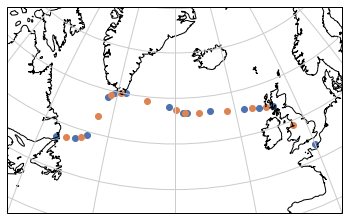

In [17]:
sns.set(style="whitegrid")
central_lon, central_lat = -30, 55
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
extent = [-60, 0, 40, 70]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')

lonlat.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat')
lonlat2mean.plot.scatter(ax=ax,transform=ccrs.PlateCarree(),x='lon',y='lat');

## plot tracks by source region

In [18]:
# range of stations from west to east, stations 0-12. Python indexing.

def plotTracksCartopy(ds1,cmap=co.cm.tempo_r,title='',fig_path = Path.cwd(),fileroot='',date = ''):
    
    central_lon, central_lat = -45, 47.5
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize = (12,8),subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
    extent = [-80, -10, 25, 70]
    ax.set_extent(extent)
    ax.gridlines()
    ax.coastlines(resolution='50m')
    
    dsmask = ds1

    pcm = ax.scatter(
        dsmask.lon.data.flatten(),
        dsmask.lat.data.flatten(),
        3,
#         (dsmask.time.data.flatten()-ds.time.isel(obs=0,traj=0).data).astype('timedelta64[D]')
        mdates.date2num(dsmask.time.data.flatten())
#         ,cmap= cmap
        ,zorder=2
        ,transform=ccrs.PlateCarree()
    #   ,alpha=0.3
    )
    cb = fig.colorbar(pcm,ax=ax,shrink=0.8,label = "date")
    loc = mdates.MonthLocator(bymonth=range(1,13,3))
    cb.ax.yaxis.set_major_locator(loc)
    cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
#     cb.ax.tick_params(labelsize=20)


    depth.isel(y=slice(1000, 2499), x=slice(0, 2404)).plot.contour(ax=ax,transform=ccrs.PlateCarree(),
        x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500],zorder=1
    );
    ax.scatter(
        dsmask.lon.isel(obs=0).data.flatten(),
        dsmask.lat.isel(obs=0).data.flatten(),2,zorder=5,
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-58.2,-40,num=20),np.linspace(52,65,num=20),
        zorder=5,color='C2',
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-80,-58.2,num=20),np.linspace(52,52,num=20),
        zorder=5,color='C2',
        transform=ccrs.PlateCarree()
    )
    ax.plot(np.linspace(-60,-100,num=20),np.linspace(33,33,num=20),
        zorder=5,color='C2',
        transform=ccrs.PlateCarree()
    )
    
    title=ax.set_title(title)
    
    filenameroot = fig_path / str('plotTracks' + fileroot + date)

#     plt.savefig(filenameroot.with_suffix('.eps'), bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig(filenameroot.with_suffix('.png'), bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig(filenameroot.with_suffix('.pdf'), bbox_extra_artists=(title,), bbox_inches='tight')


    return


In [19]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

#### from Labrador sea or from Gulf Stream

In [20]:
# labrador sea
ds_in1, ds_notin1 = apply_left_of_line(ds,-75,-40,40,65)
ds_in2, ds_notin2 = apply_left_of_line(ds,-95,-60,52,52)
ds_lab_sea_in = ds_in1*ds_in2
# 60w
ds_in, ds_notin = apply_left_of_line(ds,-60,-60,33,63)
ds_60w_in = ds_in
# gulf stream
ds_in, ds_notin = apply_left_of_line(ds,-60,-100,33,33)
ds_gs_in = ds_in


In [21]:
# particles on osnap line
ds_init_labsea = ds_init.where(ds_lab_sea_in.max("obs"))
ds_init_60w = ds_init.where(ds_60w_in.max("obs")).where(ds_lab_sea_in.max("obs"))
ds_init_gs = ds_init.where(ds_gs_in.max("obs")).where(ds_lab_sea_in.max("obs")==False)
ds_init_other = ds_init.where(ds_60w_in.max("obs")==False).where(ds_lab_sea_in.max("obs")==False)

# particles throughout tracking timespan
ds_lab_sea = ds.where(ds_lab_sea_in.max("obs"))
ds_60w = ds.where(ds_60w_in.max("obs")).where(ds_lab_sea_in.max("obs"))
ds_gs = ds.where(ds_gs_in.max("obs")).where(ds_lab_sea_in.max("obs")==False)
ds_other = ds.where(ds_lab_sea_in.max("obs")==False).where(ds_60w_in.max("obs")==False) 

In [22]:
t=[]

for name,group in ds_init.groupby("time"):
    t.append(name)  
    
display(t)


[numpy.datetime64('2006-01-16T12:00:00.000000000'),
 numpy.datetime64('2006-07-16T12:00:00.000000000'),
 numpy.datetime64('2007-01-16T12:00:00.000000000'),
 numpy.datetime64('2007-07-16T12:00:00.000000000'),
 numpy.datetime64('2008-01-16T12:00:00.000000000'),
 numpy.datetime64('2008-07-16T12:00:00.000000000'),
 numpy.datetime64('2009-01-16T12:00:00.000000000'),
 numpy.datetime64('2009-07-16T12:00:00.000000000'),
 numpy.datetime64('2010-01-16T12:00:00.000000000'),
 numpy.datetime64('2010-07-16T12:00:00.000000000'),
 numpy.datetime64('2011-01-16T12:00:00.000000000'),
 numpy.datetime64('2011-07-16T12:00:00.000000000'),
 numpy.datetime64('2012-01-16T12:00:00.000000000'),
 numpy.datetime64('2012-07-16T12:00:00.000000000'),
 numpy.datetime64('2013-01-16T12:00:00.000000000'),
 numpy.datetime64('2013-07-16T12:00:00.000000000'),
 numpy.datetime64('2014-01-16T12:00:00.000000000'),
 numpy.datetime64('2014-07-16T12:00:00.000000000'),
 numpy.datetime64('2015-01-16T12:00:00.000000000'),
 numpy.datet

### Particles reaching OSNAP section, 20-30W 0-500 m depth, from Labrador Sea.

It is difficult to see any change in the volume transort of water on this route from these plots, but there is a change in the pattern, with many fewer of the 2017 particles taking the southern loop down the east coast of Canada/USA than the 2006 particles.

This supports the Holliday et al idea of different routes out of the Labrador Sea influencing temperature/salinity in near-surface Iceland Basin. It also suggests a possible negative link between near-surface temperature in Iceland Basin and Atlantic coast of NE USA/Canada.

#### select by release date

In [23]:
date = str(t[0].astype('datetime64[D]'))
display(date)

'2006-01-16'

In [24]:
test = ds_lab_sea.where(ds_lab_sea_in.cumsum(dim='obs') < 1)
ds_select = test.where(test.isel(obs=0).time == t[0]).dropna('traj', how='all')

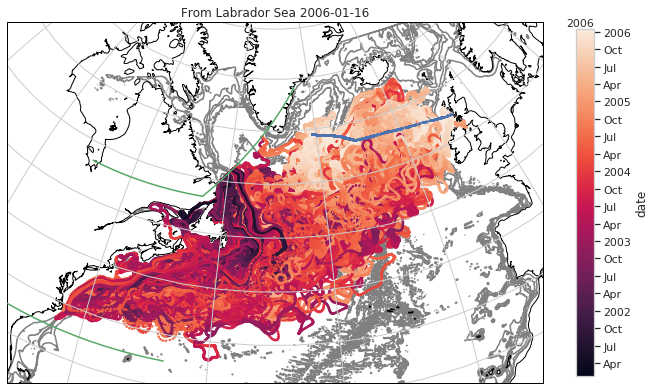

In [25]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From Labrador Sea '+date,fig_path = project_path / figures_path, fileroot='Lab',date=date)

In [26]:
date = str(t[-6].astype('datetime64[D]'))
display(date)

'2016-01-16'

In [27]:
test = ds_lab_sea.where(ds_lab_sea_in.cumsum(dim='obs') < 1)
ds_select = test.where(test.isel(obs=0).time == t[-6]).dropna('traj', how='all')

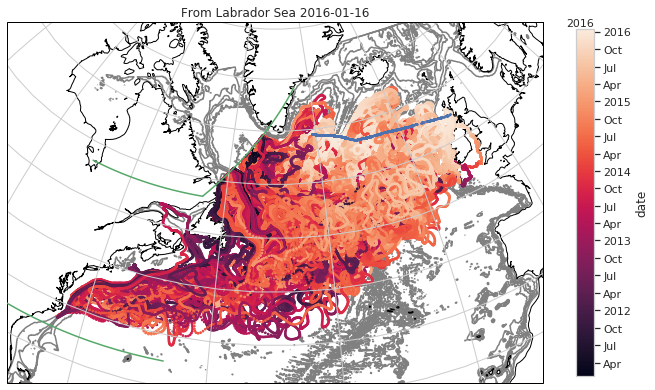

In [28]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From Labrador Sea '+date,fig_path = project_path / figures_path, fileroot='Lab',date=date)

### Particles reaching OSNAP section, 20-30W 0-500 m depth, from Gulf Stream.

This shows with fewer of the 2017 particles reaching the OSNAP line from the Gulf Stream (tested crossing 33N) than 2006 particles.

I think this supports the ideas of Bryden et al (2020?), with cooling/freshening in eastern subpolar gyre following reduced surface heat/salt transport northwards from Gulf Stream to subpolar N Atlantic.

In [29]:
date = str(t[0].astype('datetime64[D]'))
display(date)

'2006-01-16'

In [30]:
test = ds_gs.where(ds_gs_in.cumsum(dim='obs') < 1)
ds_select = test.where(test.isel(obs=0).time == t[0]).dropna('traj', how='all')

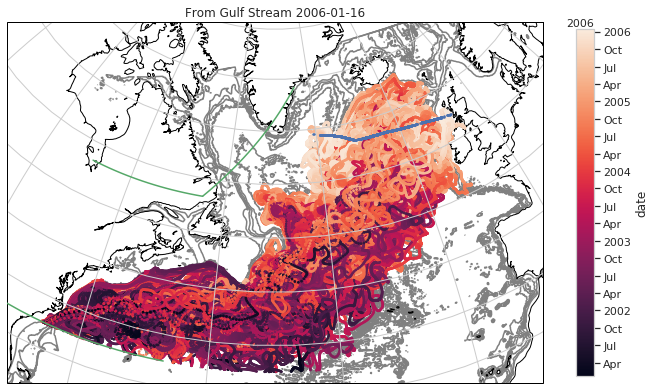

In [31]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From Gulf Stream '+date,fig_path = project_path / figures_path, fileroot='GS',date=date)

In [32]:
date = str(t[-6].astype('datetime64[D]'))
display(date)

'2016-01-16'

In [33]:
test = ds_gs.where(ds_gs_in.cumsum(dim='obs') < 1)
ds_select = test.where(test.isel(obs=0).time == t[-6]).dropna('traj', how='all')

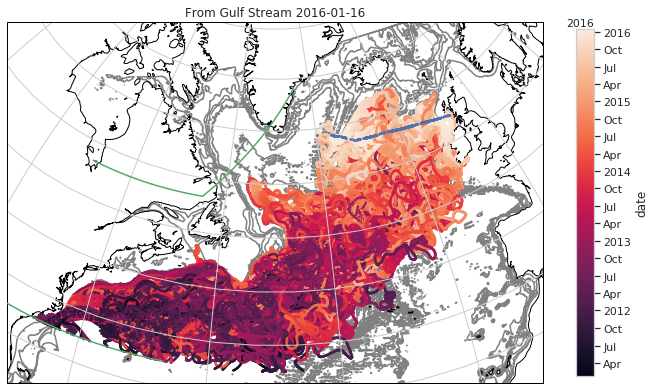

In [34]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From Gulf Stream '+date,fig_path = project_path / figures_path, fileroot='GS',date=date)

### Other particles reaching OSNAP section, 20-30W 0-500 m depth.

However, there are a lot of particles for which running backwards for 4 years isn't long enough to determine whether they came from the Labrador Sea or the Gulf Stream, as they spent the whole of that time in the N Atlantic (N of 33N, not in Labrador Sea).

In [35]:
date = str(t[0].astype('datetime64[D]'))
display(date)

'2006-01-16'

In [36]:
ds_select = ds_other.where(ds_other.isel(obs=0).time == t[0]).dropna('traj', how='all')

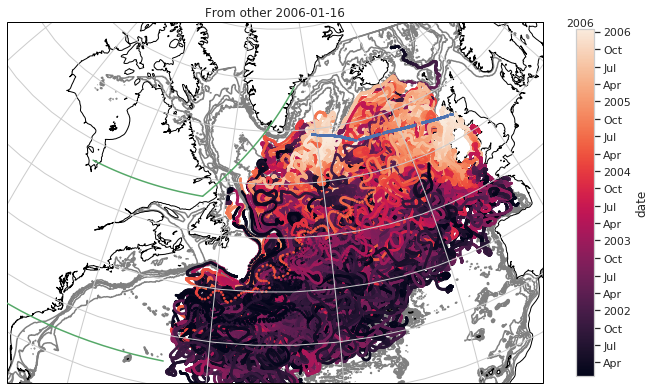

In [37]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From other '+date,fig_path = project_path / figures_path, fileroot='Other',date=date)

In [38]:
date = str(t[-1].astype('datetime64[D]'))
display(date)

'2018-07-16'

In [39]:
ds_select = ds_other.where(ds_other.isel(obs=0).time == t[-1]).dropna('traj', how='all')

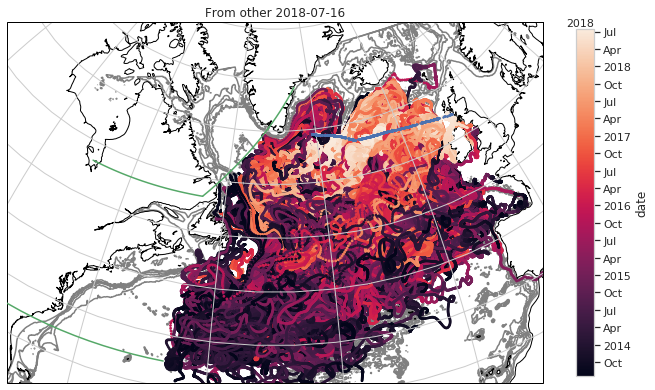

In [40]:
plotTracksCartopy(ds_select,cmap=co.cm.tempo_r,title='From other '+date,fig_path = project_path / figures_path, fileroot='Other',date=date)

In [41]:
# ds_ffill = ds.where(ds.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')
# ds_lab_sea_ffill = ds_lab_sea.where(ds_lab_sea.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')
# ds_60w_ffill = ds_60w.where(ds_60w.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')
# ds_other_ffill = ds_other.where(ds_other.temp!=0.0).dropna('traj', how='all').ffill(dim='obs')

In [42]:
def plot_alongtrack_av_timeseries(dsi,dsi_init,title_text):
    sns.set(style="darkgrid")
    sns.set_palette("Paired")
    
    fig,ax = plt.subplots(2,figsize = (13,12),sharex=True)

    for name,group in dsi_init.groupby("time"):
        ds_temp = dsi.where(dsi.isel(obs=0).time == name).dropna('traj', how='all')
        t=ds_temp.time.min(dim='traj')
        ax[0].plot(t,ds_temp.temp.mean(dim='traj'))
        ax[1].plot(t,ds_temp.salt.mean(dim='traj'))
        
    ax[0].set_ylim(2.5,18.5)
    ax[1].set_ylim(34.41,36.15)    
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_ylabel('mean salinity [PSU]')

    title=fig.suptitle(title_text + '  plot_alongtrack_av_timeseries')
#     plt.savefig('plot_alongtrack_av_timeseries'+title_text+'.eps', bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig('plot_alongtrack_av_timeseries'+title_text+'.png', bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig('plot_alongtrack_av_timeseries'+title_text+'.pdf', bbox_extra_artists=(title,), bbox_inches='tight')
    
    return

In [43]:
def plot_alongtrack_av_flux_timeseries(dsi,dsi_init, title_text):
    sns.set(style="darkgrid")
    sns.set_palette("Paired")

    fig,ax = plt.subplots(2,figsize = (13,12),sharex=True)

    for name,group in dsi_init.groupby("time"):
        ds_temp = dsi.where(dsi.isel(obs=0).time == name).dropna('traj', how='all')
        t = ds_temp.time.min(dim='traj')
        ax[0].plot(t,
                ds_temp.temp_transport.sum(dim='traj')/ds_temp.vol_transport.sum(dim='traj'))
        ax[1].plot(t,
                ds_temp.salt_transport.sum(dim='traj')/ds_temp.vol_transport.sum(dim='traj'))
        
    ax[0].set_ylim(2.5,18.5)
    ax[1].set_ylim(34.41,36.15)
    
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_ylabel('mean salinity [PSU]')

    title=fig.suptitle(title_text + '  plot_alongtrack_av_flux_timeseries')
#     plt.savefig('plot_alongtrack_av_flux_timeseries'+title_text+'.eps', bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig('plot_alongtrack_av_flux_timeseries'+title_text+'.png', bbox_extra_artists=(title,), bbox_inches='tight')
#     plt.savefig('plot_alongtrack_av_flux_timeseries'+title_text+'.pdf', bbox_extra_artists=(title,), bbox_inches='tight')


In [44]:
# plot_alongtrack_av_timeseries(ds_ffill,ds_init, 'all_particles')


In [45]:
# plot_alongtrack_av_timeseries(ds_lab_sea_ffill,ds_init_labsea, 'from_labrador_sea')

In [46]:
# plot_alongtrack_av_timeseries(ds_60w_ffill,ds_init_60w, 'from_gulf_stream')

In [47]:
# plot_alongtrack_av_timeseries(ds_other_ffill,ds_init_other, 'other_particles')

In [48]:
# plot_alongtrack_av_flux_timeseries(ds_ffill,ds_init, 'all_particles')


In [49]:
# plot_alongtrack_av_flux_timeseries(ds_lab_sea_ffill,ds_init_labsea, 'from_labrador_sea')

In [50]:
# plot_alongtrack_av_flux_timeseries(ds_60w_ffill,ds_init_60w, 'from_gulf_stream')

In [51]:
# plot_alongtrack_av_flux_timeseries(ds_other_ffill,ds_init_other, 'other_particles')

In [23]:
def plot_transports_by_source():

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (9,15),sharex=True)

    ds_init.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='total')
    ds_init_labsea.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    ds_init_gs.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    ds_init_other.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)

    ds_init.groupby("time").sum().temp_transport.plot(ax=ax[1],label='total')
    ds_init_labsea.groupby("time").sum().temp_transport.plot(ax=ax[1],label='labrador sea')
    ds_init_gs.groupby("time").sum().temp_transport.plot(ax=ax[1],label='gulf stream')
    ds_init_other.groupby("time").sum().temp_transport.plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')
    ax[1].set_ylim(bottom=0)

    ds_init.groupby("time").sum().salt_transport.plot(ax=ax[2],label='total')
    ds_init_labsea.groupby("time").sum().salt_transport.plot(ax=ax[2],label='labrador sea')
    ds_init_gs.groupby("time").sum().salt_transport.plot(ax=ax[2],label='gulf stream')
    ds_init_other.groupby("time").sum().salt_transport.plot(ax=ax[2],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
    ax[2].set_ylim(bottom=0)

    ds_init.groupby("time").sum().particle_vol.plot(ax=ax[3],label='total')
    ds_init_labsea.groupby("time").sum().particle_vol.plot(ax=ax[3],label='labrador sea')
    ds_init_gs.groupby("time").sum().particle_vol.plot(ax=ax[3],label='gulf stream')
    ds_init_other.groupby("time").sum().particle_vol.plot(ax=ax[3],label='other')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('volume [$m^3 x 10^6$]')
    ax[3].set_xlabel('')
    ax[3].set_ylim(bottom=0)

    (ds_init.groupby("time").sum().vol_trans_normal/ds_init.groupby("time").sum().particle_vol).plot(ax=ax[4],label='total')
    (ds_init_labsea.groupby("time").sum().vol_trans_normal/ds_init_labsea.groupby("time").sum().particle_vol).plot(ax=ax[4],label='labrador sea')
    (ds_init_gs.groupby("time").sum().vol_trans_normal/ds_init_gs.groupby("time").sum().particle_vol).plot(ax=ax[4],label='gulf stream')
    (ds_init_other.groupby("time").sum().vol_trans_normal/ds_init_other.groupby("time").sum().particle_vol).plot(ax=ax[4],label='other')
    ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('average u_normal [$m s^{-1}$]')
    ax[4].set_xlabel('')
    ax[4].set_ylim(bottom=0)


    title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig('plot_transports_by_source.eps', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    plt.savefig('plot_transports_by_source_37WtoScot.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_transports_by_source.pdf', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return


In [24]:
def plot_transport_anomalies_by_source():

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)

    (ds_init.groupby("time").sum().vol_trans_normal - 
     ds_init.groupby("time").sum().vol_trans_normal.mean()).plot(ax=ax[0],label='total')
    (ds_init_labsea.groupby("time").sum().vol_trans_normal-
     ds_init_labsea.groupby("time").sum().vol_trans_normal.mean()).plot(ax=ax[0],label='labrador sea')
    (ds_init_gs.groupby("time").sum().vol_trans_normal-
    ds_init_gs.groupby("time").sum().vol_trans_normal.mean()).plot(ax=ax[0],label='gulf stream')
    (ds_init_other.groupby("time").sum().vol_trans_normal-
     ds_init_other.groupby("time").sum().vol_trans_normal.mean()).plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')

    (ds_init.groupby("time").sum().temp_transport-
     ds_init.groupby("time").sum().temp_transport.mean()).plot(ax=ax[1],label='total')
    (ds_init_labsea.groupby("time").sum().temp_transport-
     ds_init_labsea.groupby("time").sum().temp_transport.mean()).plot(ax=ax[1],label='labrador sea')
    (ds_init_gs.groupby("time").sum().temp_transport-
     ds_init_gs.groupby("time").sum().temp_transport.mean()).plot(ax=ax[1],label='gulf stream')
    (ds_init_other.groupby("time").sum().temp_transport-
     ds_init_other.groupby("time").sum().temp_transport.mean()).plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('temperature transport [Sv $\degree$C]')
    ax[1].set_xlabel('')

    (ds_init.groupby("time").sum().salt_transport-
     ds_init.groupby("time").sum().salt_transport.mean()).plot(ax=ax[2],label='total')
    (ds_init_labsea.groupby("time").sum().salt_transport-
     ds_init_labsea.groupby("time").sum().salt_transport.mean()).plot(ax=ax[2],label='labrador sea')
    (ds_init_gs.groupby("time").sum().salt_transport-
     ds_init_gs.groupby("time").sum().salt_transport.mean()).plot(ax=ax[2],label='gulf stream')
    (ds_init_other.groupby("time").sum().salt_transport-
     ds_init_other.groupby("time").sum().salt_transport.mean()).plot(ax=ax[2],label='other')
    lgd=ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('salt transport [Sv PSU]')
   


    title=fig.suptitle('Transport anomalies across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
    
#     plt.savefig('plot_transports_by_source.eps', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    plt.savefig('plot_transport_anomalies_by_source_37WtoScot.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('plot_transports_by_source.pdf', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return


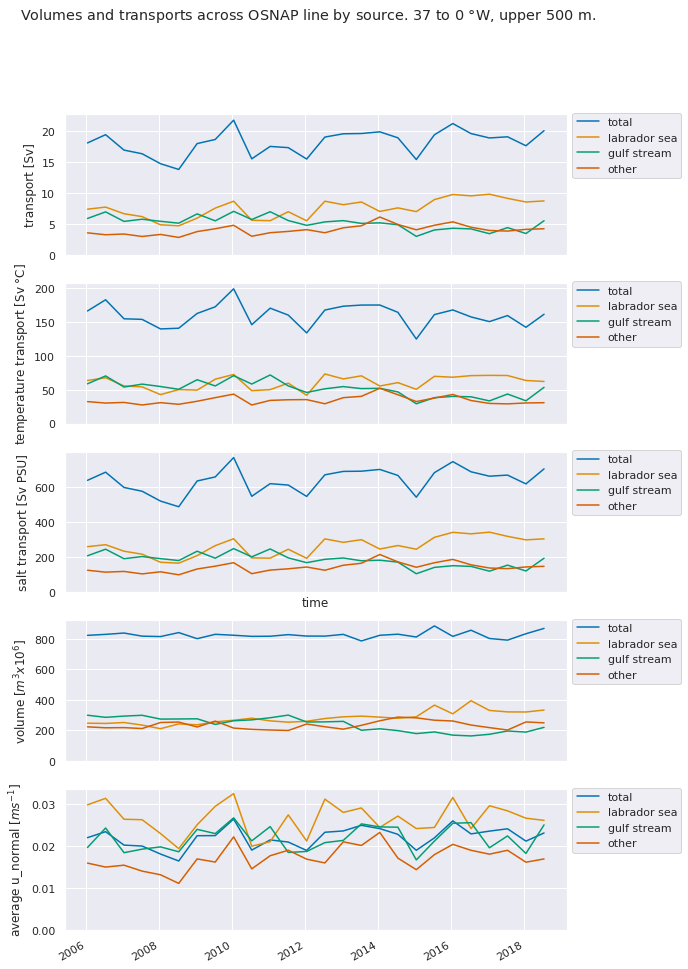

In [25]:
plot_transports_by_source()

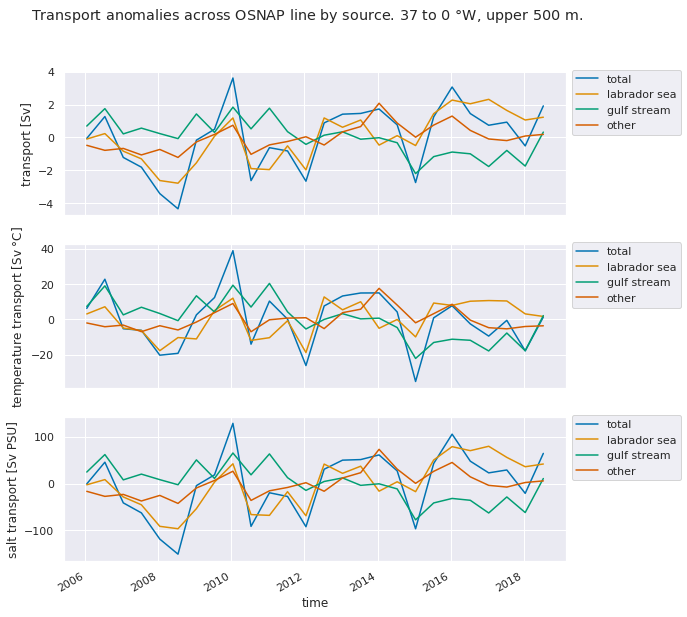

In [26]:
plot_transport_anomalies_by_source()

In [56]:
def plot_volume_mean_properties_by_source():
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(5,figsize = (8,13),sharex=True)

    dsivol=ds_init.groupby("time").sum().particle_vol
    dsivol_labsea=ds_init_labsea.groupby("time").sum().particle_vol
    dsivol_gs=ds_init_gs.groupby("time").sum().particle_vol
    dsivol_other=ds_init_other.groupby("time").sum().particle_vol
    
    dsigtm=ds_init.groupby("time").sum()
    dsigtm_labsea=ds_init_labsea.groupby("time").sum()
    dsigtm_gs=ds_init_gs.groupby("time").sum()
    dsigtm_other=ds_init_other.groupby("time").sum()

    ds_init.groupby("time").sum().particle_vol.plot(ax=ax[0],label='total')
    ds_init_labsea.groupby("time").sum().particle_vol.plot(ax=ax[0],label='labrador sea',color='C1')
    ds_init_gs.groupby("time").sum().particle_vol.plot(ax=ax[0],label='gulf stream',color='C2')
    ds_init_other.groupby("time").sum().particle_vol.plot(ax=ax[0],label='other',color='C3')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('volume [$m^3 x 10^6$]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)

    (dsigtm.tempxvol/dsivol).plot(ax=ax[1],label='total')
    (dsigtm_labsea.tempxvol/dsivol_labsea).plot(ax=ax[1],label='labrador sea')
    (dsigtm_gs.tempxvol/dsivol_gs).plot(ax=ax[1],label='gulf stream')
    (dsigtm_other.tempxvol/dsivol_other).plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean temperature [$\degree$C]')
    ax[1].set_xlabel('')

    (dsigtm.saltxvol/dsivol).plot(ax=ax[2],label='total')
    (dsigtm_labsea.saltxvol/dsivol_labsea).plot(ax=ax[2],label='labrador sea')
    (dsigtm_gs.saltxvol/dsivol_gs).plot(ax=ax[2],label='gulf stream')
    (dsigtm_other.saltxvol/dsivol_other).plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean salinity [PSU]')
    ax[2].set_xlabel('')

    (dsigtm.depthxvol/dsivol).plot(ax=ax[3],label='total')
    (dsigtm_labsea.depthxvol/dsivol_labsea).plot(ax=ax[3],label='labrador sea')
    (dsigtm_gs.depthxvol/dsivol_gs).plot(ax=ax[3],label='gulf stream')
    (dsigtm_other.depthxvol/dsivol_other).plot(ax=ax[3],label='other')
    ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean depth [m]')
    ax[3].invert_yaxis()
    ax[3].set_xlabel('')
    
    (dsigtm.lonxvol/dsivol).plot(ax=ax[4],label='total')
    (dsigtm_labsea.lonxvol/dsivol_labsea).plot(ax=ax[4],label='labrador sea')
    (dsigtm_gs.lonxvol/dsivol_gs).plot(ax=ax[4],label='gulf stream')
    (dsigtm_other.lonxvol/dsivol_other).plot(ax=ax[4],label='other')
    lgd3 = ax[4].legend(bbox_to_anchor=(1.0, 1.05))
    ax[4].set_ylabel('mean longitude [$\degree$E]')
    ax[4].set_xlabel('')


    title=fig.suptitle('mean_properties_on_OSNAP_by_source',y=.92)
#     plt.savefig('mean_properties_by_source.eps', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
#     plt.savefig('mean_properties_by_source.png', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
#     plt.savefig('mean_properties_by_source.pdf', bbox_extra_artists=(lgd3,title), bbox_inches='tight')
    
    
    return

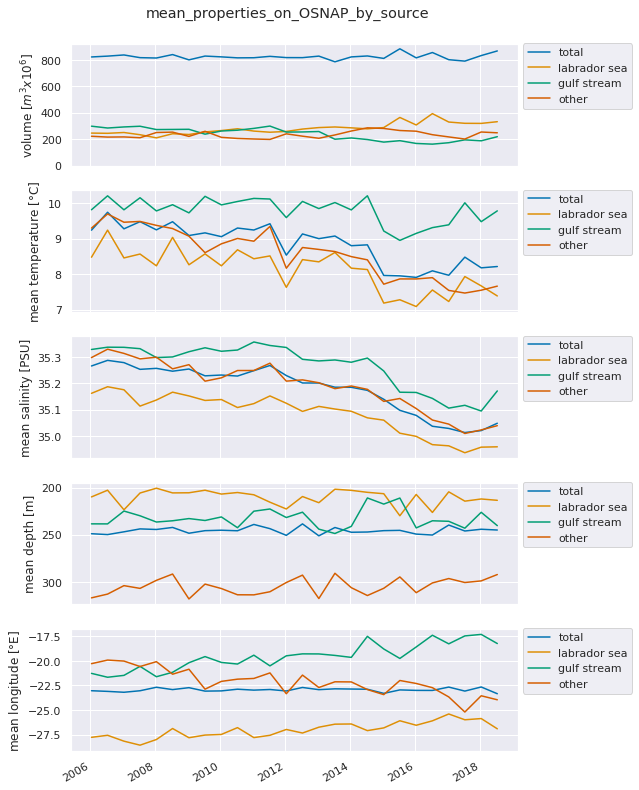

In [57]:
plot_volume_mean_properties_by_source()

In [58]:
def plot_transport_mean_properties_by_source():
    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(4,figsize = (8,10),sharex=True)

    dsigts=ds_init.groupby("time").sum()
    dsigts_labsea=ds_init_labsea.groupby("time").sum()
    dsigts_gs=ds_init_gs.groupby("time").sum()
    dsigts_other=ds_init_other.groupby("time").sum()

    
    (dsigts.temp_transport/dsigts.vol_trans_normal).plot(ax=ax[0],label='total')
    (dsigts_labsea.temp_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[0],label='labrador sea')
    (dsigts_gs.temp_transport/dsigts_gs.vol_trans_normal).plot(ax=ax[0],label='gulf stream')
    (dsigts_other.temp_transport/dsigts_other.vol_trans_normal).plot(ax=ax[0],label='other')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('mean temperature [$\degree$C]')
    ax[0].set_xlabel('')

    (dsigts.salt_transport/dsigts.vol_trans_normal).plot(ax=ax[1],label='total')
    (dsigts_labsea.salt_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[1],label='labrador sea')
    (dsigts_gs.salt_transport/dsigts_gs.vol_trans_normal).plot(ax=ax[1],label='gulf stream')
    (dsigts_other.salt_transport/dsigts_other.vol_trans_normal).plot(ax=ax[1],label='other')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('mean salinity [PSU]')
    ax[1].set_xlabel('')
    
    (dsigts.depth_transport/dsigts.vol_trans_normal).plot(ax=ax[2],label='total')
    (dsigts_labsea.depth_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[2],label='labrador sea')
    (dsigts_gs.depth_transport/dsigts_gs.vol_trans_normal).plot(ax=ax[2],label='gulf stream')
    (dsigts_other.depth_transport/dsigts_other.vol_trans_normal).plot(ax=ax[2],label='other')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('mean depth [m]')
    ax[2].invert_yaxis()
    ax[2].set_xlabel('')

    (dsigts.lon_transport/dsigts.vol_trans_normal).plot(ax=ax[3],label='total')
    (dsigts_labsea.lon_transport/dsigts_labsea.vol_trans_normal).plot(ax=ax[3],label='labrador sea')
    (dsigts_gs.lon_transport/dsigts_gs.vol_trans_normal).plot(ax=ax[3],label='gulf stream')
    (dsigts_other.lon_transport/dsigts_other.vol_trans_normal).plot(ax=ax[3],label='other')
    lgd = ax[3].legend(bbox_to_anchor=(1.0, 1.05))
    ax[3].set_ylabel('mean longitude [$\degree$E]')
    ax[3].set_xlabel('')

    title=fig.suptitle('transportweighted_mean_properties_by_source')
#     plt.savefig('transportweighted_mean_properties_by_source.eps', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('transportweighted_mean_properties_by_source.png', bbox_extra_artists=(lgd,title), bbox_inches='tight')
#     plt.savefig('transportweighted_mean_properties_by_source.pdf', bbox_extra_artists=(lgd,title), bbox_inches='tight')
    
    
    return

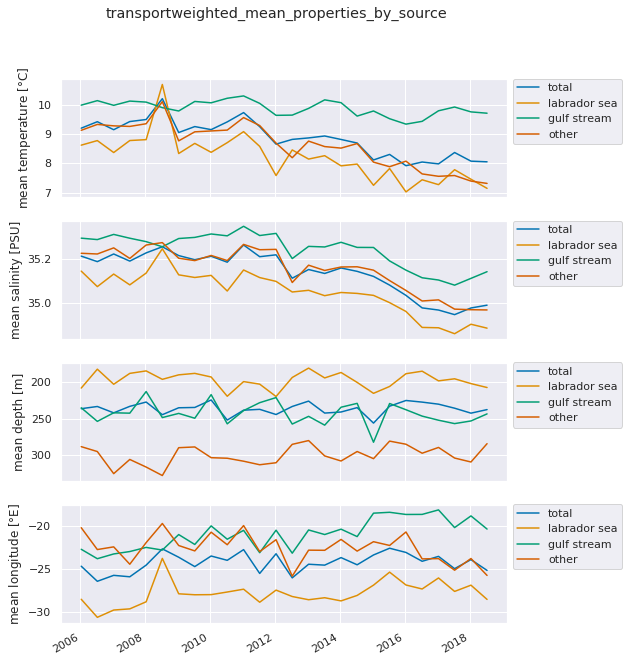

In [59]:
plot_transport_mean_properties_by_source()

In [60]:
def plot_transport_scatterplot(dsi):
    fig,ax = plt.subplots(13,figsize = (12,15),sharex=True)

    dsi_2006 = dsi.where(dsi.time == t[0]).dropna('traj', how='all')
    dsi_2007 = dsi.where(dsi.time == t[2]).dropna('traj', how='all')
    dsi_2008 = dsi.where(dsi.time == t[4]).dropna('traj', how='all')
    dsi_2009 = dsi.where(dsi.time == t[6]).dropna('traj', how='all')
    dsi_2010 = dsi.where(dsi.time == t[8]).dropna('traj', how='all')
    dsi_2011 = dsi.where(dsi.time == t[10]).dropna('traj', how='all')
    dsi_2012 = dsi.where(dsi.time == t[12]).dropna('traj', how='all')
    dsi_2013 = dsi.where(dsi.time == t[14]).dropna('traj', how='all')
    dsi_2014 = dsi.where(dsi.time == t[16]).dropna('traj', how='all')
    dsi_2015 = dsi.where(dsi.time == t[18]).dropna('traj', how='all')
    dsi_2016 = dsi.where(dsi.time == t[20]).dropna('traj', how='all')
    dsi_2017 = dsi.where(dsi.time == t[22]).dropna('traj', how='all')
    dsi_2018 = dsi.where(dsi.time == t[24]).dropna('traj', how='all')

    ax[12].scatter(dsi_2006.lon,dsi_2006.z,10,dsi_2006.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[11].scatter(dsi_2007.lon,dsi_2007.z,10,dsi_2007.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[10].scatter(dsi_2008.lon,dsi_2008.z,10,dsi_2008.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 9].scatter(dsi_2009.lon,dsi_2009.z,10,dsi_2009.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 8].scatter(dsi_2010.lon,dsi_2010.z,10,dsi_2010.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 7].scatter(dsi_2011.lon,dsi_2011.z,10,dsi_2011.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 6].scatter(dsi_2012.lon,dsi_2012.z,10,dsi_2012.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 5].scatter(dsi_2013.lon,dsi_2013.z,10,dsi_2013.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 4].scatter(dsi_2014.lon,dsi_2014.z,10,dsi_2014.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 3].scatter(dsi_2015.lon,dsi_2015.z,10,dsi_2015.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 2].scatter(dsi_2016.lon,dsi_2016.z,10,dsi_2016.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 1].scatter(dsi_2017.lon,dsi_2017.z,10,dsi_2017.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)
    ax[ 0].scatter(dsi_2018.lon,dsi_2018.z,10,dsi_2018.vol_trans_normal,cmap=co.cm.balance,vmin=-0.02,vmax=0.02)

    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    ax[2].invert_yaxis()
    ax[3].invert_yaxis()
    ax[4].invert_yaxis()
    ax[5].invert_yaxis()
    ax[6].invert_yaxis()
    ax[7].invert_yaxis()
    ax[8].invert_yaxis()
    ax[9].invert_yaxis()
    ax[10].invert_yaxis()
    ax[11].invert_yaxis()
    ax[12].invert_yaxis()
    
    return

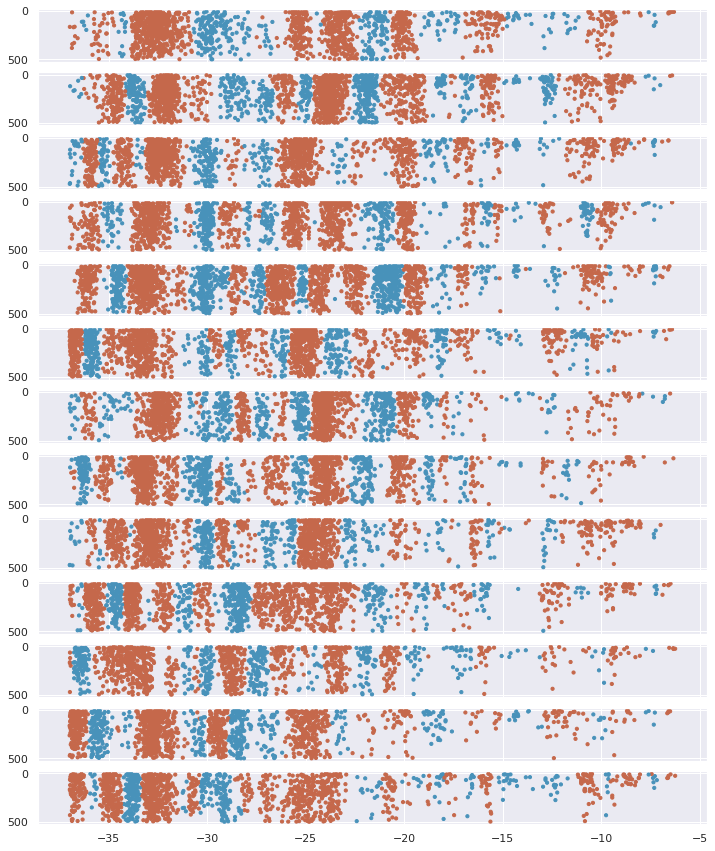

In [61]:
plot_transport_scatterplot(ds_init_labsea)

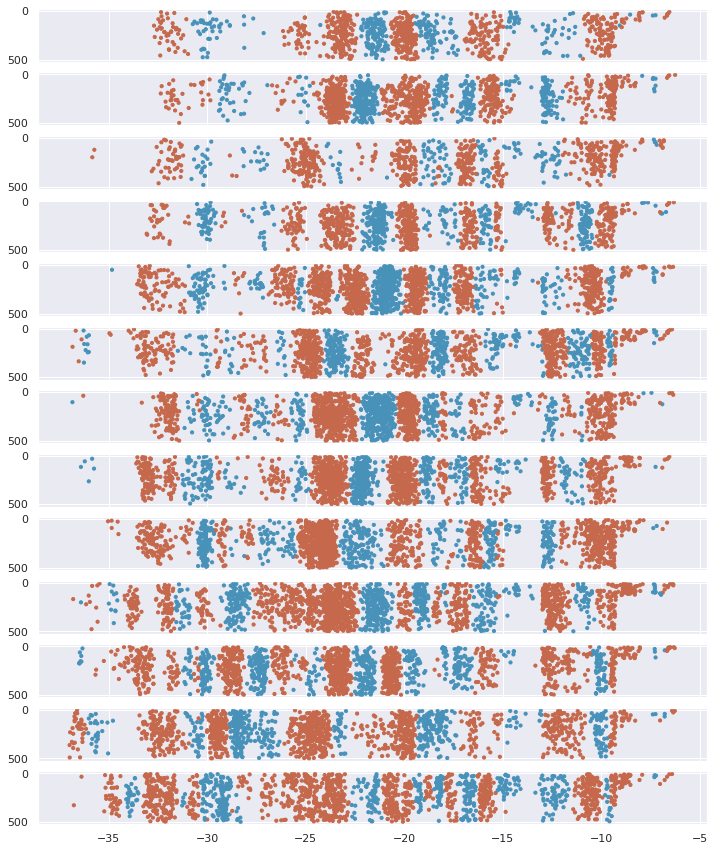

In [62]:
plot_transport_scatterplot(ds_init_gs)

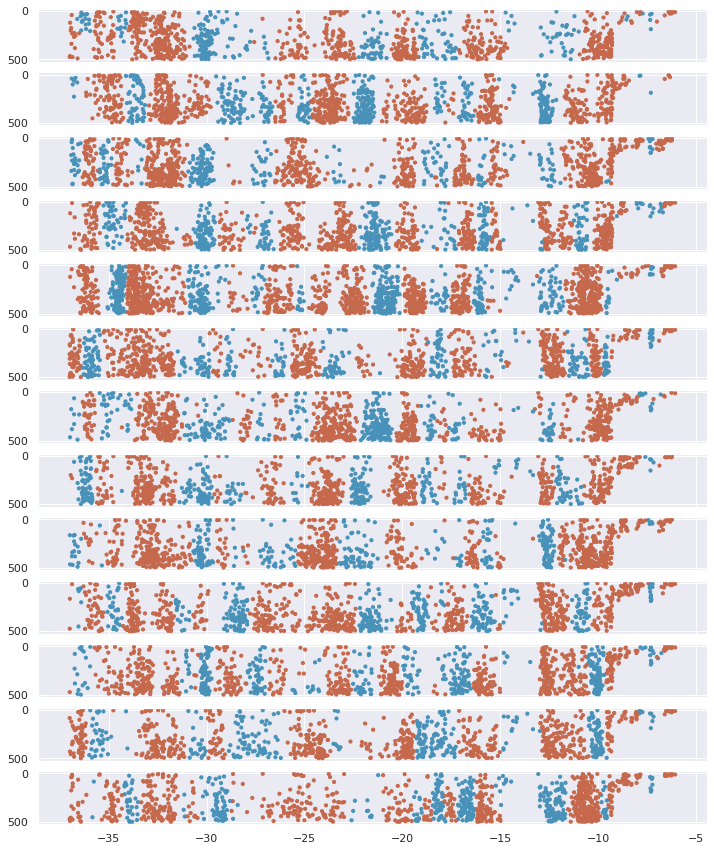

In [63]:
plot_transport_scatterplot(ds_init_other)

#### A few plots subsetting data to test whether I have enough particles

In [28]:
ds_init.isel(traj=slice(0,-1,2))

<xarray.Dataset>
Dimensions:           (traj: 64504)
Dimensions without coordinates: traj
Data variables:
    trajectory        (traj) float64 9.145e+03 9.181e+03 ... 1.309e+05 1.313e+05
    time              (traj) datetime64[ns] 2006-01-16T12:00:00 ... 2018-07-16T12:00:00
    lat               (traj) float64 59.29 59.35 59.16 59.24 ... 57.09 56.9 56.9
    lon               (traj) float64 -35.24 -35.86 -34.0 ... -7.374 -7.353
    z                 (traj) float64 209.2 350.0 141.9 ... 31.57 46.96 36.71
    temp              (traj) float32 6.2902155 4.963172 ... 11.749499 12.317391
    salt              (traj) float32 34.864887 34.92651 ... 34.721798 34.65245
    uvel              (traj) float32 3.9646687e-07 ... -5.711276e-07
    vvel              (traj) float32 7.6421816e-07 ... -2.8506886e-07
    uvel_ms           (traj) float64 0.0225 0.01564 ... -0.03213 -0.03466
    vvel_ms           (traj) float32 0.08491992 -0.014012906 ... -0.03167685
    section_index     (traj) int64 5 5 5 5 5 5 5 5 5 ... 11 11 11 11 11 11 11 11
    u_normal          (traj) float64 0.0877 -0.01063 ... -0.03643 -0.03768
    u_along           (traj) float64 0.005204 0.0181 ... -0.02569 -0.02802
    x                 (traj) float64 1.82e+03 1.784e+03 ... 3.495e+03 3.497e+03
    vol_trans_normal  (traj) float64 0.008987 -0.008987 ... -0.008987 -0.008987
    temp_transport    (traj) float64 0.05653 -0.0446 ... -0.1056 -0.1107
    salt_transport    (traj) float64 0.3133 -0.3139 -0.3141 ... -0.312 -0.3114
    depth_transport   (traj) float64 1.88 -3.146 -1.275 ... -0.422 -0.3299
    lon_transport     (traj) float64 -0.3167 0.3223 0.3055 ... 0.06627 0.06608
    particle_vol      (traj) float64 0.1025 0.8452 0.1047 ... 0.2466 0.2385
    tempxvol          (traj) float64 0.6446 4.195 0.7438 ... 3.659 2.898 2.938
    saltxvol          (traj) float64 3.573 29.52 3.66 ... 9.703 8.564 8.265
    depthxvol         (traj) float64 21.44 295.9 14.86 ... 8.676 11.58 8.755
    lonxvol           (traj) float64 -3.611 -30.31 -3.56 ... -1.819 -1.754
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

In [49]:
def plot_transports_by_source_particle_quantity_test():

    sns.set(style="darkgrid")
    sns.set_palette("colorblind")
    fig,ax = plt.subplots(3,figsize = (9,9),sharex=True)

    ds_init.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='total')
    ds_init_labsea.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='labrador sea')
    ds_init_gs.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='gulf stream')
    ds_init_other.groupby("time").sum().vol_trans_normal.plot(ax=ax[0],label='other')
    eulerian_transport.trsp.plot(ax=ax[0],label='true')
    ax[0].legend(bbox_to_anchor=(1.0, 1.05))
    ax[0].set_ylabel('transport [Sv]')
    ax[0].set_xlabel('')
    ax[0].set_ylim(bottom=0)

    (ds_init.isel(traj=slice(0,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],label='total',color='C0')
    (ds_init_labsea.isel(traj=slice(0,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],label='labrador sea',color='C1')
    (ds_init_gs.isel(traj=slice(0,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],label='gulf stream',color='C2')
    (ds_init_other.isel(traj=slice(0,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],label='other',color='C3')
    (ds_init.isel(traj=slice(1,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],color='C0')
    (ds_init_labsea.isel(traj=slice(1,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],color='C1')
    (ds_init_gs.isel(traj=slice(1,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],color='C2')
    (ds_init_other.isel(traj=slice(1,None,2)).groupby("time").sum().vol_trans_normal*2).plot(ax=ax[1],color='C3')
    ax[1].legend(bbox_to_anchor=(1.0, 1.05))
    ax[1].set_ylabel('transport [Sv]')
    ax[1].set_xlabel('')
    ax[1].set_ylim(bottom=0)
    
    (ds_init.isel(traj=slice(0,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],label='total',color='C0')
    (ds_init_labsea.isel(traj=slice(0,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],label='labrador sea',color='C1')
    (ds_init_gs.isel(traj=slice(0,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],label='gulf stream',color='C2')
    (ds_init_other.isel(traj=slice(0,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],label='other',color='C3')
    (ds_init.isel(traj=slice(1,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C0')
    (ds_init_labsea.isel(traj=slice(1,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C1')
    (ds_init_gs.isel(traj=slice(1,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C2')
    (ds_init_other.isel(traj=slice(1,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C3')
    (ds_init.isel(traj=slice(2,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C0')
    (ds_init_labsea.isel(traj=slice(2,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C1')
    (ds_init_gs.isel(traj=slice(2,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C2')
    (ds_init_other.isel(traj=slice(2,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C3')
    (ds_init.isel(traj=slice(3,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C0')
    (ds_init_labsea.isel(traj=slice(3,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C1')
    (ds_init_gs.isel(traj=slice(3,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C2')
    (ds_init_other.isel(traj=slice(3,None,4)).groupby("time").sum().vol_trans_normal*4).plot(ax=ax[2],color='C3')
    ax[2].legend(bbox_to_anchor=(1.0, 1.05))
    ax[2].set_ylabel('transport [Sv]')
    ax[2].set_xlabel('')
    ax[2].set_ylim(bottom=0)

    title=fig.suptitle('Volumes and transports across OSNAP line by source. 37 to 0 $\degree$W, upper 500 m.')
        
    return


In [50]:
sectionTransportFilename='transport37to0.nc'
eulerian_transport = xr.open_dataset(project_path / sectionPath / sectionTransportFilename)

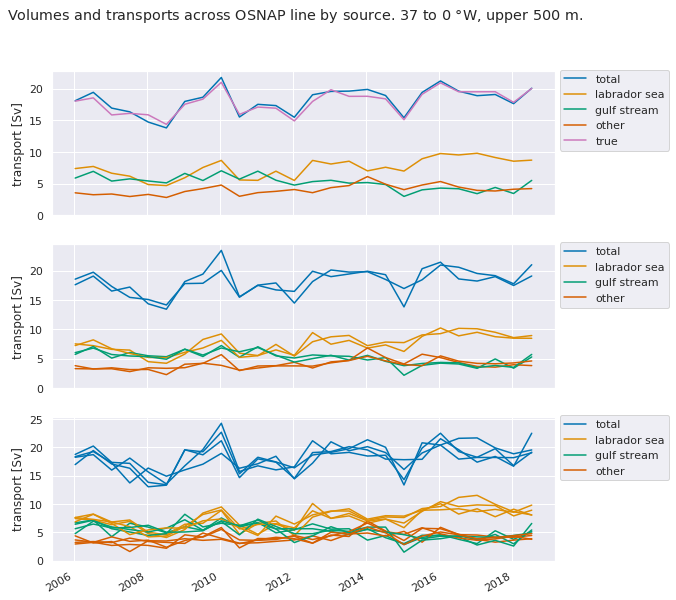

In [51]:
plot_transports_by_source_particle_quantity_test()

In [64]:
# conda list